In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [20]:
# Load the data
file_path = r"C:\Users\Anurag sharma\Downloads\Dataset_Uber Traffic (2).csv"

data = pd.read_csv(file_path)


In [21]:
# Convert 'DateTime' to datetime object
data['DateTime'] = pd.to_datetime(data['DateTime'], format='%d/%m/%y %H:%M')

In [22]:
# Remove duplicates
data = data.drop_duplicates()

In [23]:
# Aggregate traffic data by hourly intervals for each junction
data.set_index('DateTime', inplace=True)
hourly_data = data.groupby(['Junction', pd.Grouper(freq='H')]).sum().reset_index()

In [24]:
# Feature Engineering
hourly_data['hour'] = hourly_data['DateTime'].dt.hour
hourly_data['day_of_week'] = hourly_data['DateTime'].dt.dayofweek
hourly_data['month'] = hourly_data['DateTime'].dt.month
hourly_data['weekend'] = hourly_data['DateTime'].dt.dayofweek >= 5


In [25]:
# Creating lag features
for lag in range(1, 25):
    hourly_data[f'lag_{lag}'] = hourly_data.groupby('Junction')['Vehicles'].shift(lag)

In [26]:
# Drop rows with NaN values generated by lag features
hourly_data = hourly_data.dropna()


In [27]:
# Normalizing the features
scaler = StandardScaler()
hourly_data[['Vehicles']] = scaler.fit_transform(hourly_data[['Vehicles']])

In [28]:
# Splitting the data into features and target
X = hourly_data.drop(['Vehicles', 'DateTime', 'ID'], axis=1)
y = hourly_data['Vehicles']


In [29]:
# Splitting the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [30]:
# Feature importance using RandomForestRegressor
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

In [31]:
# Get feature importances
importances = model.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values(by='importance', ascending=False)

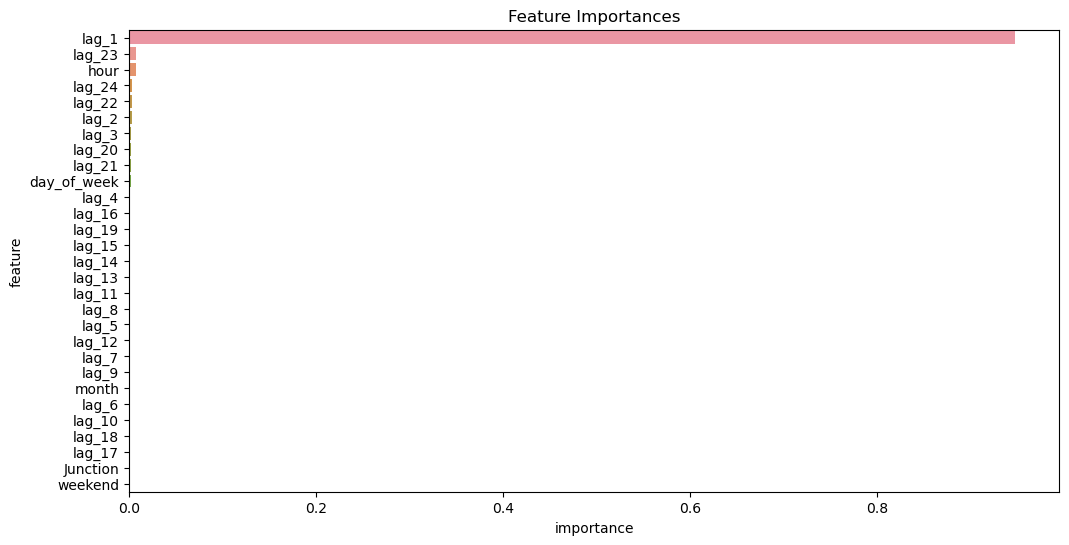

In [32]:
# Plot feature importances
plt.figure(figsize=(12,6))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importances')
plt.show()

In [34]:
# Selecting the top features
top_features = feature_importances.head(10)['feature'].values
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]


In [35]:
# Re-train the model with the top features
model.fit(X_train_top, y_train)

# Forecast future traffic volumes
forecast = model.predict(X_test_top)

In [36]:
# Evaluate the model's performance
mse = mean_squared_error(y_test, forecast)
rmse = np.sqrt(mse)

print(f'Root Mean Squared Error: {rmse}')


Root Mean Squared Error: 0.2319752419830917
